In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [ ]:
aapl=pd.read_csv("AAPL.csv")  
aapl["Date"]=aapl["Date"].astype('datetime64[ns]') # Convert column to date format
aapl.columns=["date","aapl_price"]
aapl.head()

,date,aapl_price
0,1987-05-20,0.332589
1,1987-05-21,0.332589
2,1987-05-22,0.330915
3,1987-05-26,0.348214
4,1987-05-27,0.354911


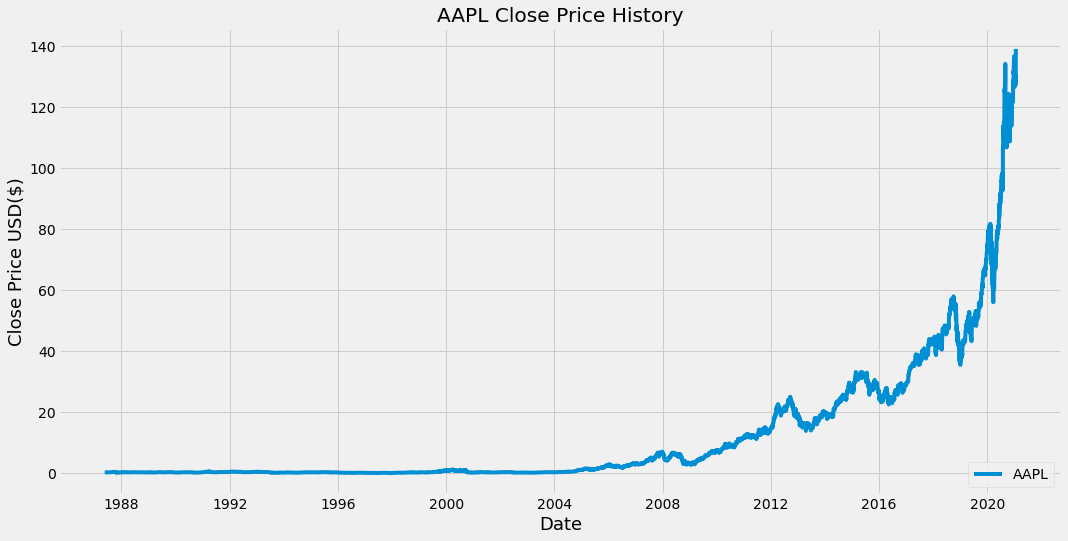

In [ ]:
plt.figure(figsize=(16,8))
plt.title('AAPL Close Price History')
plt.plot(aapl[['date','aapl_price']].set_index('date'))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.legend(['AAPL'], loc='lower right')

In [ ]:
# Loop to read all share price files and transform data
shares=["BrentOilPrices","BP"]


all_data=pd.DataFrame() # here we will store all the data from all shares and oil price in a master dataframe
for index in range(len(shares)):
    stock=pd.DataFrame()

# 1.- Read files
    stock=pd.read_csv(shares[index]+".csv")     
    stock.columns=["Date","Close"]
# 2.- Transform data
    stock=stock[["Date","Close"]]       
    stock["Date"]=stock["Date"].astype('datetime64[ns]')
    stock.columns=["date","share_price"]
    test=pd.DataFrame(aapl) # VLOOKUP equivalent in Python to merge 2 sets of data
    output=stock.merge(test,on="date",how="left")
    stock["aapl_price"]=output["aapl_price"]
    stock['share_price']=pd.to_numeric(stock['share_price'], errors='coerce').dropna(0)
    stock['aapl_price']=pd.to_numeric(stock['aapl_price'], errors='coerce').dropna(0)
    stock["year"]=pd.to_datetime(stock["date"]).dt.year # Create a column with the year to filter later
    stock["name"]=shares[index]
    stock = stock.dropna() # get rid of all the NAN rows.
# 3.- Feature Engineering. Create new column with scaled share price from 0 to 1.
#     This will help us comparing companies later on.
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler()
    stock["share_price_scaled"]=scaler.fit_transform(stock["share_price"].to_frame())
# 4.- Append data to a master dataframe
    all_data=all_data.append(stock) #append data to one matrix
    
all_data.head(-5)

,date,share_price,aapl_price,year,name,share_price_scaled
0,1987-05-20,18.630000,0.332589,1987,BrentOilPrices,0.070671
1,1987-05-21,18.450000,0.332589,1987,BrentOilPrices,0.069336
2,1987-05-22,18.550000,0.330915,1987,BrentOilPrices,0.070078
4,1987-05-26,18.630000,0.348214,1987,BrentOilPrices,0.070671
5,1987-05-27,18.600000,0.354911,1987,BrentOilPrices,0.070449
...,...,...,...,...,...,...
8478,2021-01-08,24.400000,132.050003,2021,BP,0.202667
8479,2021-01-11,24.379999,128.979996,2021,BP,0.202379
8480,2021-01-12,25.010000,128.800003,2021,BP,0.211463
8481,2021-01-13,24.780001,130.889999,2021,BP,0.208146


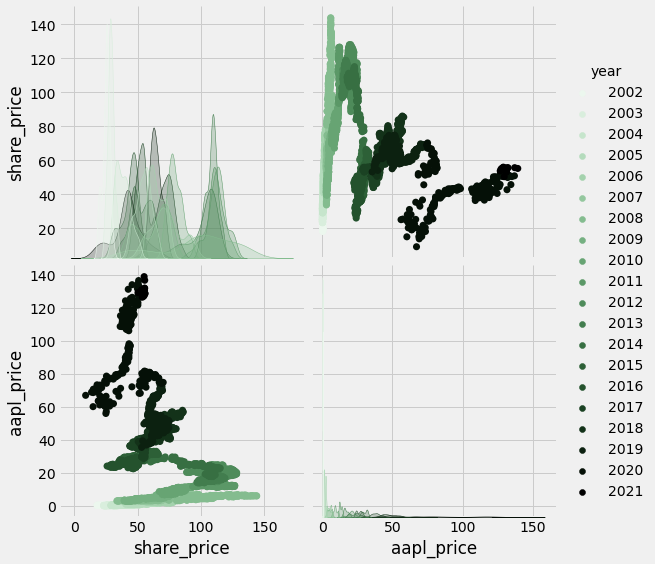

In [ ]:
#==============================================================================
# Pairplot using last 20 years data with filtering on BrentOil share price
#==============================================================================
all_data12=all_data[all_data["year"]>2001]
palette=sns.cubehelix_palette(20, start=2, rot=0, dark=0, light=.95, reverse=False)

ccc = all_data12[all_data12['name']=="BrentOilPrices"].drop(["share_price_scaled"],axis=1)
ccc.head(-5)

sns.pairplot(all_data12[all_data12['name']=="BrentOilPrices"].drop(["share_price_scaled"],axis=1),
             hue="year",palette=palette,size=4,markers="o",
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))


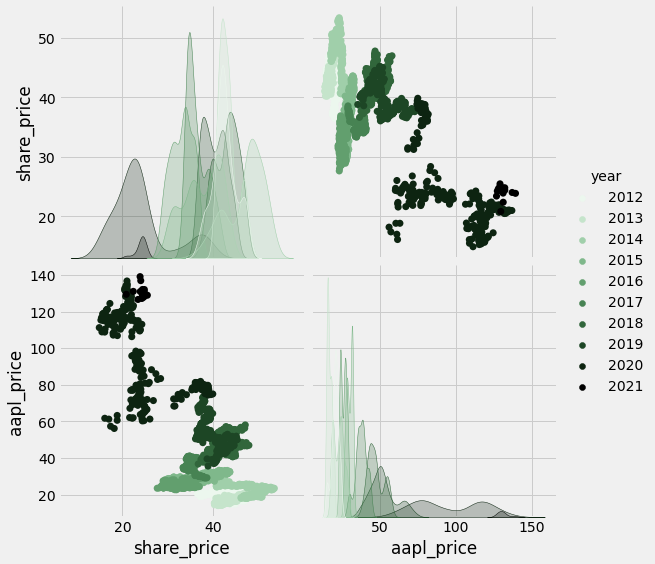

In [ ]:
#==============================================================================
# Pairplot on less data (last 5 years) using BP stock price
#==============================================================================

# to change the size of dataset increase or decrease the year and next line palette year count
all_data13=all_data[all_data["year"]>2011]
palette=sns.cubehelix_palette(10, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data13[all_data13['name']=="BP"].drop(["share_price_scaled"],axis=1),
             hue="year",palette=palette,size=4,markers="o",
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))
#all_data13.head()

In [ ]:
# Next we will construct a simple linear regression model using supervised 
# learning. The objective is to evaluate the prediction of data from the last 
# 100 days using data trained from years 2016/17 (excluding test data). 
# Train data is the data used to construct the model and test data is the data 
# we are trying to predict.

#==============================================================================
# Supervised learning linear regression
#==============================================================================

# all_data13 = 5/10 years see above worth of data

from sklearn import linear_model

# 1.- Data preparation
brentoil=pd.DataFrame()
brentoil=all_data13[(all_data13['name']=="BrentOilPrices") & (all_data13['year']>2019 )] # Extract data from years 2020/21 (2 years data)
brentoil=brentoil[["share_price","aapl_price"]].reset_index()

# Just using 1 variable for linear regression. To try with more variables use randomforest
# Split the data into training/testing sets
train = brentoil[:-100]
test = brentoil[-100:]

x_train=train["share_price"].to_frame() #converts the pandas Series to numpy.ndarray
y_train=train["aapl_price"].to_frame()
x_test=test["share_price"].to_frame() #converts the pandas Series to numpy.ndarray
y_test=test["aapl_price"].to_frame()

# 2.- Create linear regression object
regr = linear_model.LinearRegression()

# 3.- Train the model using the training sets
regr.fit(x_train,y_train)

# The coefficients
print("Coefficients: ",  float(regr.coef_))
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_train) - y_train) ** 2))

Coefficients:  0.35106278879355135
Mean squared error: 219.76


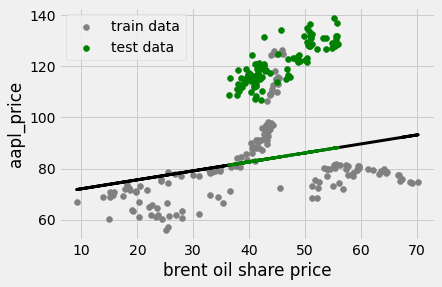

In [ ]:
# Plot outputs using matplotlib
plt_train=plt.scatter(x_train, y_train,  color='grey')
plt_test=plt.scatter(x_test, y_test,  color='green')
plt.plot(x_train, regr.predict(x_train), color='black', linewidth=3)
plt.plot(x_test,regr.predict(x_test),  color='green', linewidth=3)
plt.xlabel("brent oil share price")
plt.ylabel("aapl_price")
plt.legend((plt_train, plt_test),("train data", "test data"))
plt.show()

Random forest is an ensemble tool which takes a subset of observations and a subset of variables to build a decision trees. It builds multiple such decision tree and amalgamate them together to get a more accurate and stable prediction.

Random forest algorithm accepts more than one variable in the input data to predict the output. It runs very efficiently on large databases, its very accurate, can handle many input variables, it has effective methods for estimating missing data and many more advantages. The main disadvantage is overfitting for some tasks or some sets of data. That leads with innacurate predictions. It is also biased in favor of categorical attributes(if used) with more levels. In anycase we are gonna give it a go.

In top of the oil price, we are going to use other variables to predict the share price of Shell. These are going to be the prices of Premier Oil, Cairn Energy, TOTAL and ENGIE. I know this doesn't make much sense, but we just want to see how to construct a model of this type. It will allow us to see the impact of each one on the final prediction.

In [ ]:
# Load share price of other variables


from sklearn.ensemble import RandomForestRegressor
# 1.- Data Preparation
aapl_df=pd.DataFrame()
aapl_df=all_data13[(all_data13['year']>2015 )]
aapl_df=aapl_df[["date", "aapl_price"]].reset_index()

aapl_df = aapl_df[-400:].reset_index() # adjust this between 1500 and 150 to limit or increase data

#all_data13.head(-5)

# Load share price of other variables
# aapl_df['BrentOilPrices']=all_data13[(all_data13['name']=="BrentOilPrices")][-373:].reset_index()['share_price']
#aapl_df['BP']=all_data13[(all_data13['name']=="BP")][-373:].reset_index()['share_price']

aapl_df['BrentOilPrices']=all_data13[(all_data13['name']=="BrentOilPrices")].reset_index()['share_price']
aapl_df['BP']=all_data13[(all_data13['name']=="BP")].reset_index()['share_price']

# aapl_df.dropna(3)
aapl_df.head(-1)
train = aapl_df[:-100]
test = aapl_df[-100:]
# train.head(-1)

# aapl_df.head(-1)
x_train=train[["BrentOilPrices","BP"]]
y_train=train['aapl_price']

x_test=test[["BrentOilPrices","BP"]] 
y_test=test['aapl_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor = RandomForestRegressor(n_estimators=200, max_depth=5 )

# 3.- Train data
clf=regressor.fit(x_train, y_train)

# 4.- Predict!
y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)

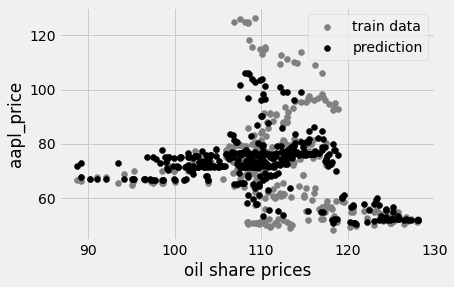

In [ ]:
# We are going to have a look at how fitted data looks like:

x_train.head()
plt_train=plt.scatter(x_train["BrentOilPrices"],y_train,   color='grey')
plt_pred=plt.scatter(aapl_df["BrentOilPrices"], regressor.predict(aapl_df[["BrentOilPrices","BP"]]),  color='black')

plt.xlabel("oil share prices")
plt.ylabel("aapl_price")
plt.legend((plt_train,plt_pred),("train data","prediction"))
plt.show()


# This model predicts training data 
# There are many parameters to tune, but a key one is max depth. This will provide the depth of the trees.

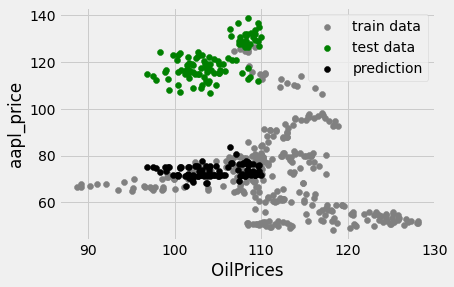

In [39]:
# predict test data now
plt_train=plt.scatter(x_train["BrentOilPrices"],y_train,   color='grey')
plt_test=plt.scatter(x_test["BrentOilPrices"],y_test,   color='green')
plt_pred=plt.scatter(x_test["BrentOilPrices"], y_pred,  color='black')

plt.xlabel("OilPrices")
plt.ylabel("aapl_price")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

In [40]:
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

Mean squared error: 122.06


If you see the mean squared error, we manage to reduce the error from 183.02 to 48.46. 

It is always worth to give it a check to the importance of each parameter:

Feature ranking:
Feature BrentOilPrices (0.343123)
Feature BP (0.656877)


Text(0, 0.5, 'Importance')

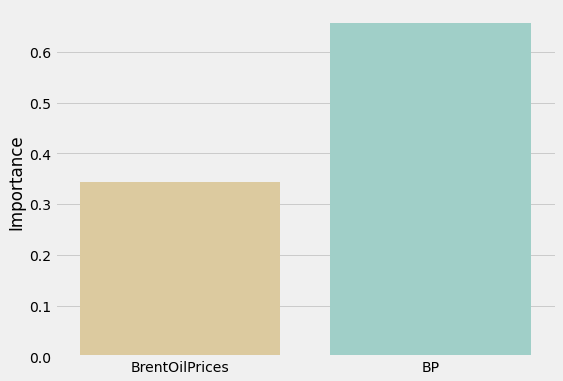

In [ ]:
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")

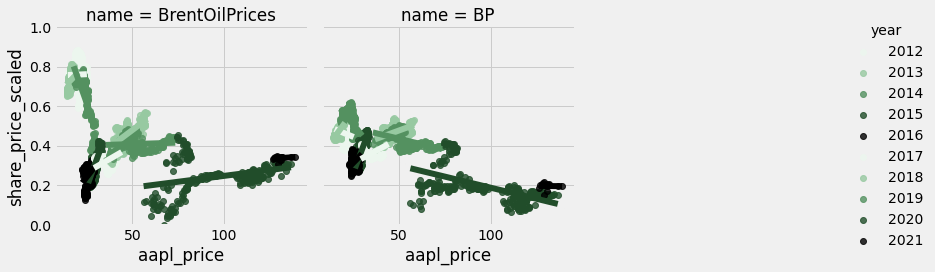

In [ ]:
#We dont really see that much on that chart. Lets add different colors for each year and see if correlations are telling us anything.

palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.lmplot(x="aapl_price", y="share_price_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=all_data13, order=1,palette=palette,size=4).set(ylim=(0, 1))

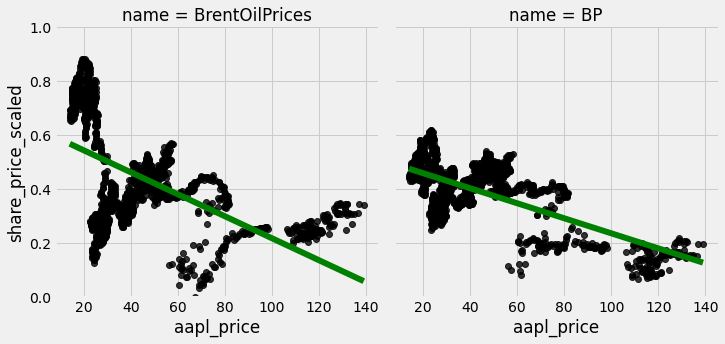

In [ ]:
#Plot of oil price vs share price of different companies using different templates
#The next analysis will do a grid of charts for all companies to check if we see any patterns.
#==============================================================================
# lmplot using using 5 years for all companies
#==============================================================================

sns.lmplot(x="aapl_price", y="share_price_scaled", col="name",ci=None, col_wrap=3, 
           data=all_data13, order=1,line_kws={'color': 'green'},scatter_kws={'color': 'black'}).set(ylim=(0, 1))